# <center>Locally-weighted Logistic Regression</center>
### <center>Calvin Chi</center>
---

The locally-weighted logistic regression problem is to maximize

$$\ell(\theta) = -\frac{\lambda}{2}\theta^{T}\theta + \sum_{i = 1}^{m}w^{(i)}\left[y^{(i)}\log h_{\theta}(x^{(i)}) + (1 - y^{(i)})\log (1 - h_{\theta}(x^{(i)}))\right]$$

where notations are according to notes1 from [Stanford's CS229](http://cs229.stanford.edu/materials.html). Find the (1) matrix-representation of the gradient $\nabla_{\theta}\ell(\theta)$ and for the (2) hessian $H$. We can the $\hat{\theta}$ that maximizes $\ell(\theta)$ via the Newton-Raphson method.

$$\theta := \theta - H^{-1}\nabla_{\theta}\ell(\theta)$$

Let us find $\nabla_{\theta}\ell(\theta)$ and $H$

Let $\sigma(x^{(i)}) = h_{\theta}(x^{(i)})$, then $\frac{d\sigma(x^{(i)})}{dz} = \sigma(x^{(i)}) (1 - \sigma(x^{(i)})$ is true. 

$$\frac{\partial \log \sigma(x^{(i)})}{\partial \theta_{j}} = \frac{1}{\sigma(x^{(i)})}\sigma(x^{(i)}) (1 - \sigma(x^{(i)})x_{j}^{(i)} = (1 - \sigma(x^{(i)}))x_{j}^{(i)}$$

$$\frac{\partial \log (1 - \sigma(x^{(i)}))}{\partial \theta_{j}} = - \frac{\sigma(x^{(i)})}{1 - \sigma(x^{(i)})}(1 - \sigma(x^{(i)}))x_{j}^{(i)} = -\sigma(x^{(i)})x_{j}^{(i)}$$

Hence piecing it all together

\begin{align*}
\frac{\partial \ell(\theta)}{\partial \theta_{j}} &= -\lambda \theta_{j} + \sum_{i = 1}^{m}x_{j}^{(i)}w^{(i)}(y^{(i)} - h_{\theta}(x^{(i)}))\\
\nabla_{\theta}\ell(\theta) &= -\lambda \theta + X^{T}z
\end{align*}

Where $z \in \mathbb{R}^{m \times 1}$ is defined as

$$z_{i} = w^{(i)}(y^{(i)} - h_{\theta}(x^{(i)}))$$

To find the Hessian

$$\frac{\partial^{2} \ell(\theta)}{\partial \theta_{j} \theta_{k}} = -\lambda \mathbb{1}(j = k) - \sum_{i = 1}^{m}x_{j}^{(i)}w^{(i)}h_{\theta}(x^{(i)})(1 - h_{\theta}(x^{(i)}))x_{k}^{(i)}$$

$$H = X^{T}DX - \lambda I$$

where $D \in \mathbb{R}^{m \times m}$ is a diagonal matrix with 

$$D_{ii} = -w^{(i)}h_{\theta}(x^{(i)})(1 - h_{\theta}(x^{(i)}))$$

Now for the implementation. Load libraries

In [21]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

Load a sample datasets

In [2]:
DATA_DIR = "datasets/CS229_P1"
X = pd.DataFrame(np.loadtxt(DATA_DIR + "/x.dat"))
Y = pd.DataFrame(np.loadtxt(DATA_DIR + "/y.dat"))

Here is the locally-weighted logistic regression using the Newton-Raphson method.

In [17]:
def weights(x_train, x, tau):
    sq_diff = (x_train - x)**2
    norm_sq = sq_diff.sum(axis = 1)
    return np.ravel(np.exp(- norm_sq / (2 * tau**2)))

def logistic(theta, x_train):
    return np.ravel(1 / (1 + np.exp(-x_train.dot(theta))))

def lwlr(x_train, y_train, x, tau):
    reg = 0.0001
    threshold = 1e-6
    theta = np.zeros(x_train.shape[1])
    w = weights(x_train, x, tau)
    # Compute gradient
    h = logistic(theta, x_train)
    z = w * (np.ravel(y_train) - h)
    gradient = x_train.transpose().dot(z) - reg * theta
    # Compute Hessian
    D = np.diag(-(w * h * (1 - h)))
    H = x_train.transpose().dot(D).dot(x_train) - reg * np.identity(x_train.shape[1])
    while np.linalg.norm(gradient) > threshold:
        theta = theta - np.linalg.inv(H).dot(gradient)
        # compute gradient
        h = logistic(theta, x_train)
        z = w * (np.ravel(y_train) - h)
        gradient = x_train.transpose().dot(z) - reg * theta
        # Compute Hessian
        D = np.diag(-(w * h * (1 - h)))
        H = x_train.transpose().dot(D).dot(x_train) - reg * np.identity(x_train.shape[1])
    return np.array(x.dot(theta) > 0.5).astype(int)

Here is a function to plot the resulting classifier.

In [29]:
def plot_lwlr(x_train, y_train, tau, res):
    # Setup plotting grid
    xx, yy = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    # Make predictions
    x = np.zeros(2)
    pred = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            x[0] = xx[i, j]
            x[1] = yy[i, j]
            pred[i, j] = lwlr(x_train, y_train, x, tau)
    # Plotting
    plt.figure()
    plt.pcolormesh(xx, yy, pred, cmap=cmap_light)
    plt.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c = y_train, cmap=cmap_bold)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("tight")
    plt.title("tau = " + str(tau))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

Let us evaluate the system with a variety of different bandwidth parameters $\tau = 0.05, 0.1, 0.5, 1$

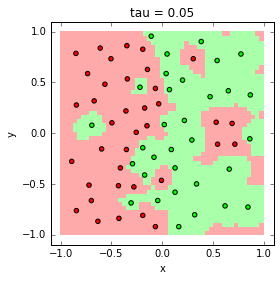

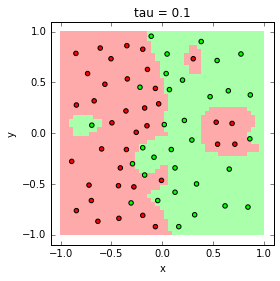

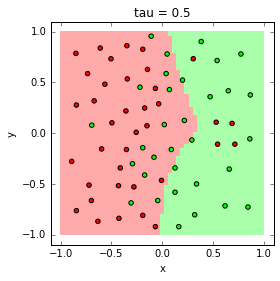

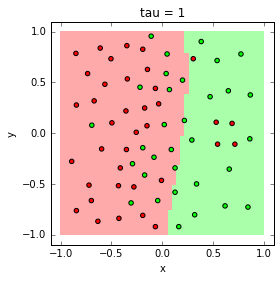

In [30]:
%matplotlib inline
tau = [0.05, 0.1, 0.5, 1]

for i in range(1, len(tau) + 1):
    plot_lwlr(X, Y, tau[i-1], 50)

It appears that as $\tau$ increases, the decision boundary becomes smoother and converges to unweighted logistic regression. The parameter $\tau$ is related to the weight according to

$$w^{(i)} = \text{exp}\left(-\frac{||x - x^{(i)}||^{2}}{2\tau^{2}}\right)$$

As $\tau \rightarrow \infty$, $w^{(i)} \rightarrow 1$, and thus it does not matter how close $x^{(i)}$ is to the query point $x$, converging towards unweighted logistic regression. On the other hand, if $\tau$ is small then the effect of how close $x^{(i)}$ is to $x$ results in greater weight and thus greater say in the decision boundary.